# 1. Configuración del Entorno de Trabajo

En esta sección importamos las librerías necesarias para el ciclo de vida del proyecto:
* **Manipulación de Datos:** `pandas` y `numpy` para el manejo de estructuras de datos.
* **Visualización:** `matplotlib` y `seaborn` para el análisis exploratorio gráfico.
* **Imputación Avanzada:** Utilizamos `IterativeImputer` (MICE) de Scikit-Learn para el tratamiento estadístico de valores nulos.


In [21]:
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Scikit-Learn para Preprocesamiento
# enable_iterative_imputer es necesario porque MICE es aún experimental en sklearn
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer


# 2. CONFIGURACIÓN GLOBAL


# Ignorar advertencias no críticas para mantener limpia la salida del notebook
warnings.filterwarnings('ignore')

# Configuración visual para reportes profesionales
sns.set_style("whitegrid")         # Fondo con cuadrícula suave para mejor lectura
sns.set_context("notebook", font_scale=1.1) # Tamaño de fuente legible
plt.rcParams['figure.figsize'] = (12, 6)    # Tamaño por defecto de los gráficos

# Formato de números en Pandas: 
# Muestra 2 decimales y evita notación científica (ej: 1.5e6 -> 1500000.00)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("✅ Entorno configurado: Librerías cargadas y estilos definidos.")

✅ Entorno configurado: Librerías cargadas y estilos definidos.


# 2. Ingesta de Datos y Limpieza Estructural

Procedemos a la carga del dataset y realizamos una primera limpieza estructural para asegurar la calidad de los datos antes del análisis.

**Pasos realizados:**
1.  **Lectura del Archivo:** Carga del CSV crudo desde la ruta local.
2.  **Eliminación de Identificadores:** Se elimina la columna `id` ya que es un identificador único de base de datos que no aporta valor predictivo al modelo (introduce ruido).
3.  **Gestión de Duplicados:** Se identifican y eliminan registros idénticos. En *Real Estate*, es común que una misma propiedad se publique varias veces (scraping duplicado), lo cual sesgaría el análisis estadístico.

In [22]:
# 2. CARGA DE DATOS 

ruta_archivo = 'C:\\Users\\PC\\Desktop\\DataScience-Inmuebles\\data\\02_inmuebles_caba.csv'

try:
    df = pd.read_csv(ruta_archivo)
    print("✅ Carga Exitosa.")
    print(f"   -> Dimensiones iniciales: {df.shape[0]:,} filas x {df.shape[1]} columnas")
except FileNotFoundError:
    print("❌ CRÍTICO: No se encuentra el archivo. Verifica la ruta.")


# 3. LIMPIEZA ESTRUCTURAL

# 1. Eliminar ID (Variable no predictiva)
if 'id' in df.columns:
    df = df.drop(['id'], axis=1)
    print("   -> Columna 'id' eliminada correctamente.")

# 2. Eliminar Duplicados (Data Integrity)
duplicados = df.duplicated().sum()

if duplicados > 0:
    print(f"⚠️ Se detectaron {duplicados} registros duplicados.")
    # Mantenemos la primera aparición ('first') y borramos las repeticiones
    df = df.drop_duplicates(keep="first")
    print(f"   -> Registros duplicados eliminados.")
else:
    print("✅ No se encontraron registros duplicados.")

print(f"\n📊 Dimensiones post-limpieza: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Muestra de control (Sanity Check)
print("\nVista previa de los datos (5 casos aleatorios):")
display(df.sample(5, random_state=42))

✅ Carga Exitosa.
   -> Dimensiones iniciales: 14,372 filas x 15 columnas
   -> Columna 'id' eliminada correctamente.
⚠️ Se detectaron 1564 registros duplicados.
   -> Registros duplicados eliminados.

📊 Dimensiones post-limpieza: 12,808 filas x 14 columnas

Vista previa de los datos (5 casos aleatorios):


,precio_venta_usd,precio_expensas,barrio,sup_total,ambientes,baños,dormitorios,sup_cubierta,antiguedad,orientacion,cocheras,apto_mascotas,apto_profesional,estado
11682,115000.00,58538.00,Belgrano,NaN,2.00,1.00,1.00,32.96,25-50 años,NaN,NaN,NaN,NaN,excelente
4396,118000.00,NaN,Almagro,NaN,2.00,1.00,1.00,46.00,NaN,norte,NaN,NaN,NaN,bueno
1383,120000.00,123000.00,Palermo,NaN,2.00,1.00,1.00,38.00,5-10 años,NaN,NaN,1.00,1.00,excelente
7711,155000.00,NaN,Floresta,NaN,3.00,1.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,muy bueno
8842,123000.00,NaN,Villa Lugano,NaN,3.00,1.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Tratamiento de Valores Nulos (Missing Values)

Aplicamos una **Estrategia Híbrida** de tres niveles para manejar la ausencia de datos sin introducir sesgos:

1.  **Imputación por Lógica de Negocio (Domain Knowledge):**
    * En Real Estate, si el campo `cocheras` o `amenities` está vacío, el estándar de la industria es asumir que la propiedad **no posee** dicha característica (se imputa con 0), en lugar de asumir que es un dato perdido.

2.  **Eliminación por Escasez de Datos (Thresholding):**
    * Las columnas que superan el **70% de valores nulos** se eliminan. Tratar de imputar una columna casi vacía introduciría demasiado ruido artificial al modelo.

3.  **Imputación Estadística Avanzada (MICE):**
    * Para variables numéricas críticas (`sup_cubierta`, `baños`, `precio`), no usamos el promedio simple. Utilizamos el algoritmo **MICE (Multivariate Imputation by Chained Equations)**.
    * *Funcionamiento:* MICE utiliza las relaciones entre las otras variables (ej: a mayor precio, más probable es que tenga más baños) para estimar el valor faltante con alta precisión.

In [23]:
# 4. ESTRATEGIA DE IMPUTACIÓN DE NULOS

print("\n INICIANDO TRATAMIENTO DE VALORES NULOS")
nulos_inicio = df.isnull().sum().sum()
print(f"Total de celdas vacías al inicio: {nulos_inicio:,}")

# A. IMPUTACIÓN POR LÓGICA DE NEGOCIO 

# Si no está especificado, asumimos que NO tiene (0)
fill_zeros = ['cocheras', 'apto_mascotas', 'apto_profesional']

for col in fill_zeros:
    if col in df.columns:
        nulos_col = df[col].isnull().sum()
        if nulos_col > 0:
            df[col] = df[col].fillna(0)
            print(f"   -> Lógica de Negocio: Se imputaron {nulos_col} nulos en '{col}' con 0.")


# B. ELIMINACIÓN POR ESCASEZ (Threshold > 70%)

umbral = 70
porcentaje_nulos = df.isnull().mean() * 100
cols_a_eliminar = porcentaje_nulos[porcentaje_nulos > umbral].index.tolist()

if cols_a_eliminar:
    print(f"   -> 🗑️ Eliminando columnas con >{umbral}% nulos: {cols_a_eliminar}")
    df = df.drop(columns=cols_a_eliminar)
else:
    print("   -> Ninguna columna superó el umbral de nulos para eliminación.")


# C. IMPUTACIÓN ESTADÍSTICA (MICE / Iterative Imputer)
# Variables numéricas clave que necesitamos recuperar
cols_mice = ['precio_venta_usd', 'precio_expensas', 'ambientes', 'baños', 'dormitorios', 'sup_cubierta']
cols_mice = [c for c in cols_mice if c in df.columns] # Solo las que sobrevivieron

print(f"   -> Ejecutando  MICE para imputar: {cols_mice}")

# Configuramos MICE: random_state asegura que los resultados sean reproducibles
mice_imputer = IterativeImputer(max_iter=10, random_state=42)

# Aplicamos la imputación
df[cols_mice] = mice_imputer.fit_transform(df[cols_mice])

# D. AJUSTE FINAL (Redondeo)
# MICE puede devolver "2.9 baños". Redondeamos a enteros lógicos.
cols_enteros = ['ambientes', 'baños', 'dormitorios']
for col in cols_enteros:
    if col in df.columns:
        df[col] = df[col].round()

# Verificación final
nulos_final = df[cols_mice].isnull().sum().sum()
print(f"✅ Proceso finalizado. Nulos restantes en variables clave: {nulos_final}")


 INICIANDO TRATAMIENTO DE VALORES NULOS
Total de celdas vacías al inicio: 71,944
   -> Lógica de Negocio: Se imputaron 11012 nulos en 'cocheras' con 0.
   -> Lógica de Negocio: Se imputaron 10989 nulos en 'apto_mascotas' con 0.
   -> Lógica de Negocio: Se imputaron 10194 nulos en 'apto_profesional' con 0.
   -> 🗑️ Eliminando columnas con >70% nulos: ['sup_total']
   -> Ejecutando  MICE para imputar: ['precio_venta_usd', 'precio_expensas', 'ambientes', 'baños', 'dormitorios', 'sup_cubierta']
✅ Proceso finalizado. Nulos restantes en variables clave: 0


# 4. Estandarización de Tipos de Datos

Para garantizar la compatibilidad con las librerías de visualización (`seaborn`, `matplotlib`) y los algoritmos de Machine Learning (`scikit-learn`), convertimos todas las variables numéricas al formato estándar `float64`.

Esto previene errores comunes de tipo `TypeError` al intentar calcular correlaciones o generar gráficos de dispersión.

In [24]:
#  CONVERSIÓN Y ESTANDARIZACIÓN DE TIPOS

print("\nESTANDARIZANDO TIPOS DE DATOS")

# Lista de columnas que DEBEN ser numéricas para el análisis
cols_numericas = [
    'precio_venta_usd', 
    'precio_expensas', 
    'ambientes', 
    'baños', 
    'dormitorios', 
    'sup_cubierta'
]

count_convertidas = 0

for col in cols_numericas:
    if col in df.columns:
        # Forzamos la conversión a float (número decimal estándar)
        df[col] = df[col].astype(float)
        count_convertidas += 1

print(f"✅ Se han convertido {count_convertidas} columnas al formato 'float64'.")

# Verificación visual para el analista
print("\nVerificación de dtypes actuales:")
print(df[cols_numericas].dtypes)


ESTANDARIZANDO TIPOS DE DATOS
✅ Se han convertido 6 columnas al formato 'float64'.

Verificación de dtypes actuales:
precio_venta_usd    float64
precio_expensas     float64
ambientes           float64
baños               float64
dormitorios         float64
sup_cubierta        float64
dtype: object


# 5. Detección y Eliminación de Outliers (Limpieza de Anomalías)

En esta fase aplicamos **Filtros de Negocio (Hard Filters)** para eliminar registros erróneos o atípicos que distorsionarían las predicciones del modelo.

**Criterios aplicados:**
1.  **Superficie Excesiva:** Eliminamos propiedades con más de **1,000 m²**. En CABA, estos casos suelen ser errores de tipeo (ej: poner 5000 en vez de 50) o propiedades comerciales/industriales fuera de nuestro alcance.
2.  **Precio Fuera de Mercado:**
    * **Techo (> 4M USD):** Eliminamos propiedades de ultra-lujo que no siguen la lógica del mercado general.
    * **Precio por m² (< 500 o > 10,000 USD):** Este es el filtro de calidad más potente. Detecta propiedades sospechosamente baratas (posibles remates, errores de moneda) o absurdamente caras (errores de tipeo).

In [25]:
#  LIMPIEZA DE OUTLIERS 

filas_antes = df.shape[0]
print(f"Registros iniciales: {filas_antes:,}")

# A. FILTRO POR SUPERFICIE (Errores de tipeo comunes)

if 'sup_cubierta' in df.columns:
    df = df[df['sup_cubierta'] < 1000]


# B. FILTRO POR PRECIO TOTAL (Segmento Ultra-Lujo)

if 'precio_venta_usd' in df.columns:
    df = df[df['precio_venta_usd'] < 4000000]

# C. FILTRO POR PRECIO M2 
# Calculamos la variable auxiliar (Feature Engineering táctico)
df['precio_m2'] = df['precio_venta_usd'] / df['sup_cubierta']

# Aplicamos el rango lógico de mercado (500 USD - 10,000 USD)
df = df[(df['precio_m2'] > 500) & (df['precio_m2'] < 10000)]

# RESUMEN DE LA OPERACIÓN
filas_despues = df.shape[0]
eliminados = filas_antes - filas_despues

print(f"✅ Limpieza finalizada.")
print(f"   -> Registros conservados: {filas_despues:,}")
print(f"   -> Registros eliminados:  {eliminados:,} (Outliers/Errores)")

print("\n📊 Estadísticas del Dataset Limpio:")
display(df[['precio_venta_usd', 'sup_cubierta', 'precio_m2']].describe().round(2))

Registros iniciales: 12,808
✅ Limpieza finalizada.
   -> Registros conservados: 12,787
   -> Registros eliminados:  21 (Outliers/Errores)

📊 Estadísticas del Dataset Limpio:


,precio_venta_usd,sup_cubierta,precio_m2
count,12787.00,12787.00,12787.00
mean,144778.54,61.31,2332.39
std,129619.13,37.48,856.67
min,20000.00,13.00,520.83
25%,79000.00,39.00,1750.00
50%,110000.00,52.00,2257.00
75%,163000.00,72.00,2765.96
max,3300000.00,543.00,9405.64


# 6. Validación Visual Post-Limpieza

Antes de avanzar al modelado, realizamos una inspección visual para confirmar la coherencia de los datos.

**Objetivo del Gráfico:**
Visualizar la relación entre `Superficie Cubierta` y `Precio de Venta`, segmentando por cantidad de `Ambientes`.

**Qué buscamos validar:**
1.  **Tendencia Positiva:** A mayor superficie, mayor precio (diagonal ascendente).
2.  **Ausencia de Outliers Extremos:** No deberían verse puntos aislados muy lejos de la "nube" principal (ej: precios millonarios con superficies diminutas).
3.  **Heterocedasticidad:** Es normal observar que la dispersión de precios aumenta a medida que crece la superficie (forma de abanico), ya que las propiedades de lujo tienen tasaciones más subjetivas/variables.


GENERANDO GRÁFICO DE VALIDACIÓN


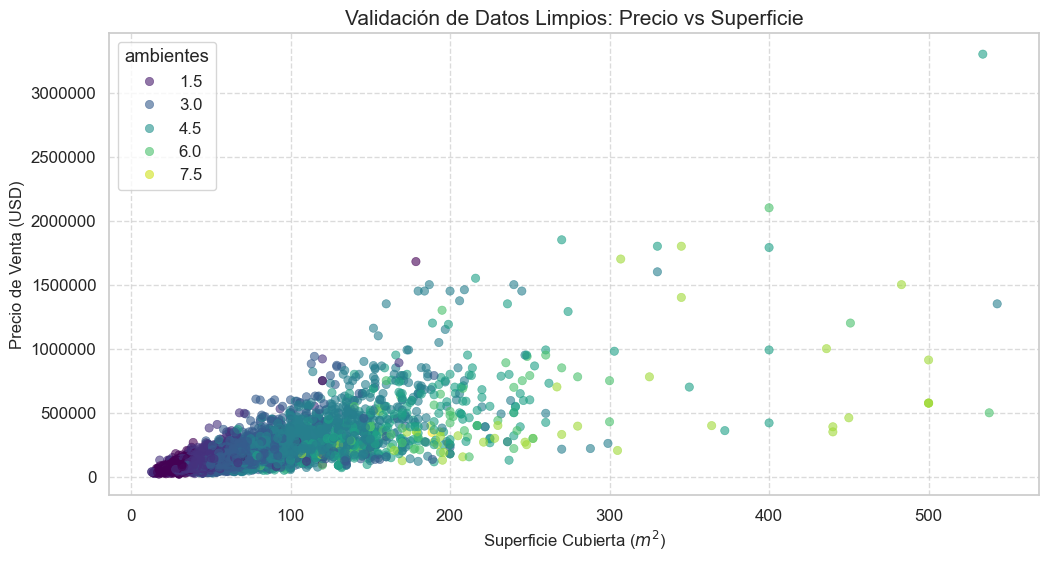

✅ Gráfico generado. Se observa una tendencia positiva clara y libre de ruido extremo.


In [26]:
# VISUALIZACIÓN DE CONTROL (Scatterplot)

print("\nGENERANDO GRÁFICO DE VALIDACIÓN")

plt.figure(figsize=(12, 6))

# Gráfico de dispersión
sns.scatterplot(
    data=df, 
    x='sup_cubierta', 
    y='precio_venta_usd', 
    hue='ambientes',    # El color indica la cantidad de ambientes
    palette='viridis',  # Paleta perceptualmente uniforme
    alpha=0.6,          # Transparencia para ver dónde se acumulan los datos
    edgecolor=None
)

# Etiquetas y títulos informativos
plt.title('Validación de Datos Limpios: Precio vs Superficie', fontsize=15)
plt.xlabel('Superficie Cubierta ($m^2$)', fontsize=12)
plt.ylabel('Precio de Venta (USD)', fontsize=12)

# Formato del eje Y (evitar notación científica 1e6)
plt.ticklabel_format(style='plain', axis='y') 
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

print("✅ Gráfico generado. Se observa una tendencia positiva clara y libre de ruido extremo.")

# 7. Análisis de Correlación (Feature Importance)

Una vez limpios los datos, analizamos las relaciones lineales entre las variables numéricas y el objetivo (`precio_venta_usd`).

**Objetivos de esta etapa:**
1.  **Identificar Drivers de Precio:** ¿Qué variables tienen mayor correlación positiva (se mueven juntas) con el precio? (Esperamos que `sup_cubierta` sea la principal).
2.  **Detectar Multicolinealidad:** Buscamos variables que estén demasiado correlacionadas entre sí (ej: `ambientes` y `dormitorios`). Si dos variables dicen lo mismo, podríamos eliminar una para simplificar el modelo y evitar redundancia.

**Interpretación del Gráfico:**
* **Rojo Intenso (+1.0):** Correlación positiva fuerte (Si A sube, B sube).
* **Azul Intenso (-1.0):** Correlación negativa fuerte (Si A sube, B baja).
* **Blanco (0.0):** Sin relación lineal aparente.


 GENERANDO MATRIZ DE CORRELACIÓN: 


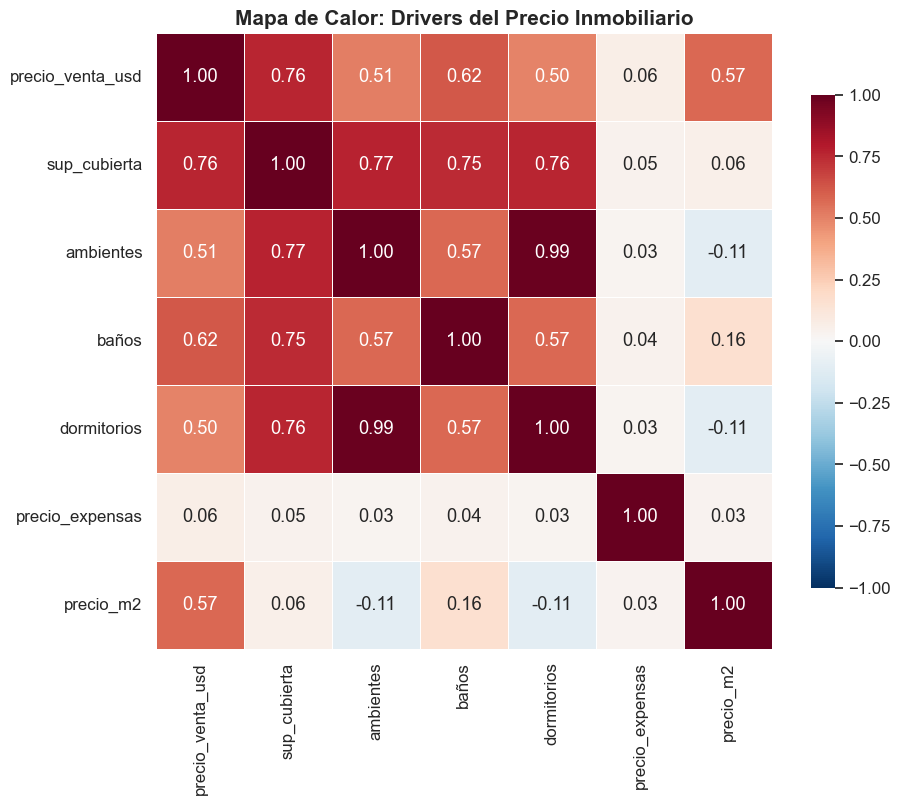

🏆 Ranking de Influencia sobre el Precio de Venta:
precio_venta_usd   1.00
sup_cubierta       0.76
baños              0.62
precio_m2          0.57
ambientes          0.51
dormitorios        0.50
precio_expensas    0.06
Name: precio_venta_usd, dtype: float64

💡 Insight: La variable más influyente es 'sup_cubierta' con una correlación de 0.76.


In [27]:
#  ANÁLISIS MULTIVARIADO: MATRIZ DE CORRELACIÓN

print("\n GENERANDO MATRIZ DE CORRELACIÓN: ")

# 1. Selección de variables numéricas relevantes
# Nota: Incluimos 'precio_m2' para análisis, pero NO debe usarse para entrenar (Data Leakage)
cols_corr = [
    'precio_venta_usd', 
    'sup_cubierta', 
    'ambientes', 
    'baños', 
    'dormitorios',
    'precio_expensas',
    'precio_m2'
]

# Filtramos para asegurar que solo usamos columnas existentes en el DF actual
cols_existentes = [c for c in cols_corr if c in df.columns]

# 2. Cálculo de correlaciones (Pearson)
matriz_corr = df[cols_existentes].corr()

# 3. Visualización (Heatmap)
plt.figure(figsize=(10, 8))

sns.heatmap(
    matriz_corr, 
    annot=True,            # Muestra el coeficiente numérico
    cmap='RdBu_r',         # Escala divergente: Rojo (+) vs Azul (-)
    fmt=".2f",             # Formato de dos decimales
    vmin=-1, vmax=1,       # Límites fijos para comparar colores correctamente
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8} # Barra de color un poco más chica estéticamente
)

plt.title('Mapa de Calor: Drivers del Precio Inmobiliario', fontsize=15, fontweight='bold')
plt.yticks(rotation=0)
plt.show()

# 4. Reporte Textual de Influencia
print("🏆 Ranking de Influencia sobre el Precio de Venta:")
ranking = matriz_corr['precio_venta_usd'].sort_values(ascending=False)
print(ranking)

# Insight:
top_feature = ranking.index[1] # El 0 es precio_venta_usd (1.0)
print(f"\n💡 Insight: La variable más influyente es '{top_feature}' con una correlación de {ranking[1]:.2f}.")

# 8. Análisis Categórico: El Factor Ubicación

El precio de una propiedad no solo depende de sus características físicas (metros, baños), sino intrínsecamente de su entorno.

**Metodología:**
1.  **Métrica de Comparación:** Utilizamos `precio_m2` en lugar del precio total. Esto neutraliza el efecto del tamaño y permite comparar justamente un monoambiente en un barrio caro contra una casa grande en un barrio económico.
2.  **Ranking:** Ordenamos los barrios por su mediana de valor.
3.  **Visualización (Boxplot):** Seleccionamos el **Top 10 (Más caros)** y el **Bottom 10 (Más accesibles)** para visualizar la brecha de desigualdad inmobiliaria en la ciudad.

**Interpretación del Gráfico:**
* **La Caja:** Representa el 50% central de los datos. Una caja ancha indica mucha variedad de precios en ese barrio.
* **La Línea Central:** Es la Mediana (el precio "típico").
* **Puntos (Outliers):** Propiedades atípicas que se escapan del rango normal del barrio.


ANALIZANDO PRECIOS POR BARRIO


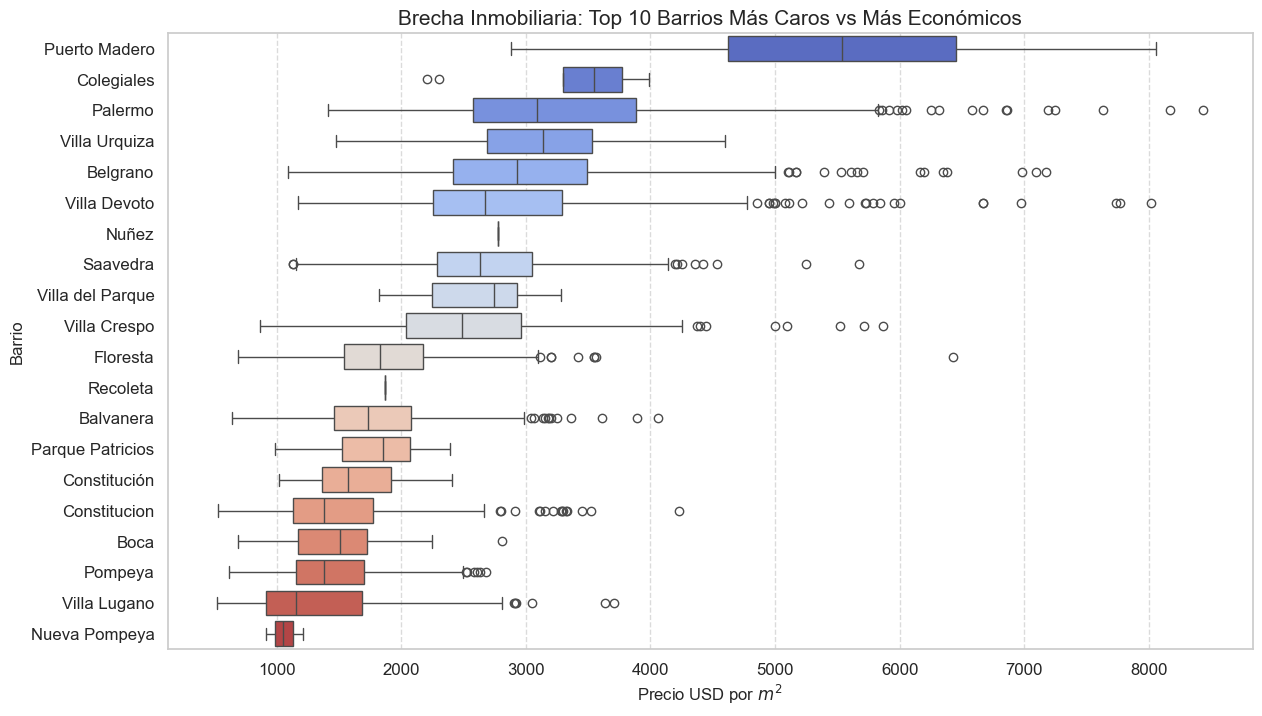

💰 Top 5 Barrios Más Exclusivos (Promedio USD/m2):
barrio
Puerto Madero   5618.92
Colegiales      3390.87
Palermo         3346.97
Villa Urquiza   3126.25
Belgrano        3050.26
Name: precio_m2, dtype: float64

📉 Top 5 Barrios Más Accesibles (Promedio USD/m2):
barrio
Constitucion    1500.97
Boca            1500.68
Pompeya         1459.48
Villa Lugano    1325.35
Nueva Pompeya   1060.06
Name: precio_m2, dtype: float64


In [28]:
# ANÁLISIS DEL FACTOR UBICACIÓN (BARRIOS)

print("\nANALIZANDO PRECIOS POR BARRIO")

# 1. Ranking de Barrios (Agrupamos por barrio y sacamos la media del m2)
# Usamos precio_m2 es la métrica más justa para comparar zonas
ranking_barrios = df.groupby('barrio')['precio_m2'].mean().sort_values(ascending=False)

# 2. Selección de Extremos (Para no saturar el gráfico con 50 barrios)
top_10 = ranking_barrios.head(10).index
bottom_10 = ranking_barrios.tail(10).index
# Unimos los dos grupos
barrios_interes = top_10.union(bottom_10)

# Filtramos el dataset solo con estos barrios para graficar
df_barrios = df[df['barrio'].isin(barrios_interes)]

# 3. Visualización: Boxplot
plt.figure(figsize=(14, 8))

# Ordenamos el eje Y según el ranking calculado previamente para que quede escalonado
orden_grafico = ranking_barrios.index[ranking_barrios.index.isin(barrios_interes)]

sns.boxplot(
    data=df_barrios,
    x='precio_m2',
    y='barrio',
    order=orden_grafico,
    palette='coolwarm', # Rojo para lo caro, Azul para lo barato (automático)
    linewidth=1.0
)

plt.title('Brecha Inmobiliaria: Top 10 Barrios Más Caros vs Más Económicos', fontsize=15)
plt.xlabel('Precio USD por $m^2$', fontsize=12)
plt.ylabel('Barrio', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

# 4. Insights Numéricos para el reporte
print("💰 Top 5 Barrios Más Exclusivos (Promedio USD/m2):")
print(ranking_barrios.head(5).round(2))

print("\n📉 Top 5 Barrios Más Accesibles (Promedio USD/m2):")
print(ranking_barrios.tail(5).round(2))

# 9. Ingeniería de Variables (Feature Engineering)

Los algoritmos de Machine Learning (como la Regresión Lineal o Random Forest) requieren entradas exclusivamente numéricas. Para incorporar variables categóricas como `barrio` o `disposición`, aplicamos la técnica de **One-Hot Encoding**.

**Transformación realizada:**
* Se generan **Variables Dummy**: Convertimos cada categoría única en una nueva columna binaria (0 o 1).
* *Ejemplo:* La columna `barrio` desaparece y nacen `barrio_Palermo`, `barrio_Belgrano`, etc.
* **Prevención de Multicolinealidad:** Utilizamos el parámetro `drop_first=True`. Esto elimina una de las columnas generadas (la categoría de referencia) para evitar redundancia matemática (la "trampa de la variable ficticia"), ya que si una propiedad no es de ningún barrio listado, por descarte pertenece al que eliminamos.

In [29]:
# TRANSFORMACIÓN DE CATEGORÍAS (ENCODING)

print("\n EJECUTANDO ONE-HOT ENCODING ")

# 1. Identificación de columnas a transformar
cols_texto = df.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categóricas detectadas: {cols_texto}")

# 2. Aplicación de Get Dummies (One-Hot Encoding)
# drop_first=True es vital para modelos lineales (evita la trampa de variables dummy)
df_procesado = pd.get_dummies(df, columns=cols_texto, drop_first=True)

print("✅ Transformación exitosa.")
print(f"   -> Dimensiones previas: {df.shape}")
print(f"   -> Dimensiones actuales: {df_procesado.shape} (Se expandió el dataset)")

# 3. Verificación de Integridad
# Nos aseguramos de que TODO sea numérico ahora
tipos_restantes = df_procesado.select_dtypes(include=['object']).columns.tolist()
if len(tipos_restantes) == 0:
    print("✅ Validación: El dataset es 100% numérico. Listo para el modelo.")
else:
    print(f"❌ ALERTA: Aún quedan columnas de texto: {tipos_restantes}")

# 4. Análisis de Impacto de las Nuevas Variables
# ¿Qué barrios suben o bajan el valor?
print("\n🏆 Ranking de Impacto (Correlación con Precio):")
corr_final = df_procesado.corr()['precio_venta_usd'].sort_values(ascending=False)

print("\n--- Top 5 Variables que VALORIZAN la propiedad ---")
print(corr_final.head(10)) # Mostramos 10 para ver sup_cubierta y los mejores barrios

print("\n--- Top 5 Variables que DESVALORIZAN la propiedad ---")
print(corr_final.tail(5))


 EJECUTANDO ONE-HOT ENCODING 
Variables categóricas detectadas: ['barrio', 'antiguedad', 'orientacion', 'estado']
✅ Transformación exitosa.
   -> Dimensiones previas: (12787, 14)
   -> Dimensiones actuales: (12787, 69) (Se expandió el dataset)
✅ Validación: El dataset es 100% numérico. Listo para el modelo.

🏆 Ranking de Impacto (Correlación con Precio):

--- Top 5 Variables que VALORIZAN la propiedad ---
precio_venta_usd       1.00
sup_cubierta           0.76
baños                  0.62
precio_m2              0.57
ambientes              0.51
dormitorios            0.50
cocheras               0.41
barrio_Puerto Madero   0.24
barrio_Palermo         0.21
barrio_Belgrano        0.16
Name: precio_venta_usd, dtype: float64

--- Top 5 Variables que DESVALORIZAN la propiedad ---
barrio_Floresta       -0.07
estado_muy bueno      -0.07
estado_bueno          -0.08
barrio_Constitucion   -0.08
barrio_Villa Lugano   -0.11
Name: precio_venta_usd, dtype: float64


# 10. Cierre de Etapa y Exportación de Datos

Hemos completado el ciclo de **Limpieza (Data Cleaning)** y **Transformación (Feature Engineering)**. El dataset actual (`df_procesado`) cumple con los requisitos para entrenar modelos predictivos:

1.  **Sin Nulos:** Imputados con lógica de negocio y MICE.
2.  **Sin Duplicados:** Registros únicos garantizados.
3.  **Sin Outliers:** Filtros de superficie y precio aplicados.
4.  **Numérico:** Todas las categorías (Barrios, Disposición) fueron convertidas a variables *dummy*.

**Acción Final:**
Guardamos el dataset procesado en un nuevo archivo CSV (`03_inmuebles_procesado_final.csv`). Este archivo será el **input** exclusivo para el siguiente notebook de Machine Learning, separando así la fase de *Análisis* de la fase de *Modelado*.

In [30]:
# EXPORTACIÓN DE DATOS PROCESADOS
print("\n--- 💾 GUARDANDO DATASET PARA MODELADO ---")

ruta_guardado = 'C:\\Users\\PC\\Desktop\\DataScience-Inmuebles\\data\\03_inmuebles_procesado_final.csv'

# Guardamos el archivo
# index=False es importante para no generar una columna extra de índices
df_procesado.to_csv(ruta_guardado, index=False)

print(f"✅ Archivo guardado exitosamente en: {ruta_guardado}")
print("🏁 Fin del Notebook de EDA. Ahora pasa al Notebook de Modelado.")


--- 💾 GUARDANDO DATASET PARA MODELADO ---
✅ Archivo guardado exitosamente en: C:\Users\PC\Desktop\DataScience-Inmuebles\data\03_inmuebles_procesado_final.csv
🏁 Fin del Notebook de EDA. Ahora pasa al Notebook de Modelado.
